<a href="https://colab.research.google.com/github/FelipeYabiko/RedeNeural/blob/main/Rede_neural_Classifica%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INTEGRANTES**

**Felipe Yabiko Nogueira | RA: 22002265**

**Henrique Ladeira Alves | RA: 23016926**

**Paulo henrique | RA: 22021948**

**Yuri Rodrigues Viegas | RA: 22021857**

**INSTALAÇÃO DE DEPENDÊNCIAS**

In [ ]:
!pip install kagglehub

**IMPORTAÇÕES**

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
                           precision_score, recall_score, f1_score, classification_report,
                           roc_auc_score, roc_curve)
import warnings
warnings.filterwarnings('ignore')

**CARREGAMENTO E EXPLORAÇÃO DOS DADOS**

In [ ]:
# Baixar dataset
path = kagglehub.dataset_download("ak0212/china-cancer-patient-records")
df = pd.read_csv(f'{path}/china_cancer_patients_synthetic.csv')

print("Formato do dataset:", df.shape)
print("\nPrimeiras 5 linhas:")
print(df.head())

print("\nInformações sobre o dataset:")
df.info()

print("\nEstatísticas descritivas:")
print(df.describe())

print("\nValores únicos da variável target (SurvivalStatus):")
print(df['SurvivalStatus'].value_counts())

100%|██████████| 218k/218k [00:00<00:00, 45.8MB/s]

Extracting files...
Formato do dataset: (10000, 20)

Primeiras 5 linhas:


   PatientID Gender  Age   Province Ethnicity TumorType CancerStage  \
0  CHN-00001   Male   32      Hunan       Han      Lung           I   
1  CHN-00002   Male   66    Sichuan       Han      Lung          IV   
2  CHN-00003  Other   26  Guangdong       Han      Lung         III   
3  CHN-00004  Other   35      Anhui    Uyghur    Breast         III   
4  CHN-00005   Male   32  Guangdong       Han   Stomach          II   

  DiagnosisDate  TumorSize Metastasis TreatmentType SurgeryDate  \
0    2010-07-24        8.2         No     Radiation  2010-08-24   
1    2015-01-03        9.5        Yes  Chemotherapy  2015-03-24   
2    2022-03-26        9.3        Yes       Surgery  2022-07-14   
3    2019-06-19        7.7         No       Surgery  2019-08-27   
4    2012-02-07        7.3         No  Chemotherapy         NaN   

   ChemotherapySessions  RadiationSessions SurvivalStatus  FollowUpMonths  \
0                     0                 23          Alive              44   
1               

**ANÁLISE EXPLORATÓRIA**

Valores ausentes por coluna:
SurgeryDate        5673
AlcoholUse         5921
GeneticMutation    7200
Comorbidities      3715
dtype: int64


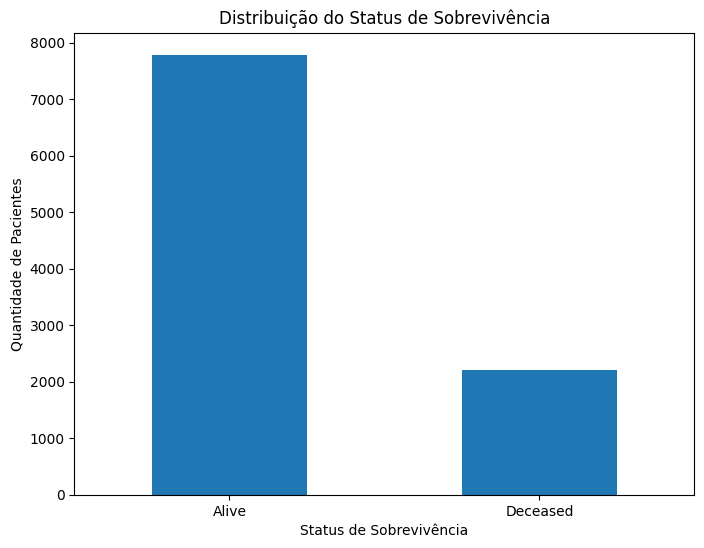


Tipos de dados:
PatientID                object
Gender                   object
Age                       int64
Province                 object
Ethnicity                object
TumorType                object
CancerStage              object
DiagnosisDate            object
TumorSize               float64
Metastasis               object
TreatmentType            object
SurgeryDate              object
ChemotherapySessions      int64
RadiationSessions         int64
SurvivalStatus           object
FollowUpMonths            int64
SmokingStatus            object
AlcoholUse               object
GeneticMutation          object
Comorbidities            object
dtype: object


In [ ]:
# Verificar valores ausentes
print("Valores ausentes por coluna:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Visualizar distribuição da variável target
plt.figure(figsize=(8, 6))
df['SurvivalStatus'].value_counts().plot(kind='bar')
plt.title('Distribuição do Status de Sobrevivência')
plt.xlabel('Status de Sobrevivência')
plt.ylabel('Quantidade de Pacientes')
plt.xticks(rotation=0)
plt.show()

# Verificar tipos de dados
print("\nTipos de dados:")
print(df.dtypes)

**PRÉ-PROCESSAMENTO DOS DADOS**

In [ ]:
# Criar cópia do dataset para trabalhar
df_processed = df.copy()

# Remover colunas irrelevantes
columns_to_drop = ['PatientID', 'DiagnosisDate', 'SurgeryDate']
df_processed = df_processed.drop(columns=columns_to_drop, errors='ignore')

print("Colunas após remoção:", df_processed.columns.tolist())

# Separar variáveis categóricas e numéricas
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
# Remover a variável target das categóricas
if 'SurvivalStatus' in categorical_cols:
    categorical_cols.remove('SurvivalStatus')

numerical_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nColunas categóricas: {categorical_cols}")
print(f"Colunas numéricas: {numerical_cols}")

# Tratar valores ausentes
print("\nTratando valores ausentes...")

# Para variáveis categóricas, substituir por 'Unknown'
for col in categorical_cols:
    df_processed[col] = df_processed[col].fillna('Unknown')

# Para variáveis numéricas, substituir pela mediana
for col in numerical_cols:
    df_processed[col] = df_processed[col].fillna(df_processed[col].median())

print("Valores ausentes após tratamento:")
print(df_processed.isnull().sum().sum())

Colunas após remoção: ['Gender', 'Age', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 'TumorSize', 'Metastasis', 'TreatmentType', 'ChemotherapySessions', 'RadiationSessions', 'SurvivalStatus', 'FollowUpMonths', 'SmokingStatus', 'AlcoholUse', 'GeneticMutation', 'Comorbidities']

Colunas categóricas: ['Gender', 'Province', 'Ethnicity', 'TumorType', 'CancerStage', 'Metastasis', 'TreatmentType', 'SmokingStatus', 'AlcoholUse', 'GeneticMutation', 'Comorbidities']
Colunas numéricas: ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths']

Tratando valores ausentes...
Valores ausentes após tratamento:
0


**CODIFICAÇÃO DE VARIÁVEIS CATEGÓRICAS**

In [ ]:
# Codificar variável target
label_encoder_target = LabelEncoder()
y = label_encoder_target.fit_transform(df_processed['SurvivalStatus'])
print(f"Classes da variável target: {label_encoder_target.classes_}")

# Aplicar One-Hot Encoding nas variáveis categóricas
df_encoded = pd.get_dummies(df_processed.drop('SurvivalStatus', axis=1),
                           columns=categorical_cols,
                           drop_first=True)

print(f"Dimensões após One-Hot Encoding: {df_encoded.shape}")
print(f"Novas colunas criadas: {df_encoded.shape[1] - len(numerical_cols)}")

Classes da variável target: ['Alive' 'Deceased']
Dimensões após One-Hot Encoding: (10000, 53)
Novas colunas criadas: 48


**NORMALIZAÇÃO DOS DADOS**

In [ ]:
# Padroniza todas as variáveis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

print(f"Dados normalizados - Shape: {X_scaled.shape}")

Dados normalizados - Shape: (10000, 53)


**ANÁLISE DA NECESSIDADE DE PCA**

Dataset possui 53 variáveis - muito grande para visualizar correlação completa


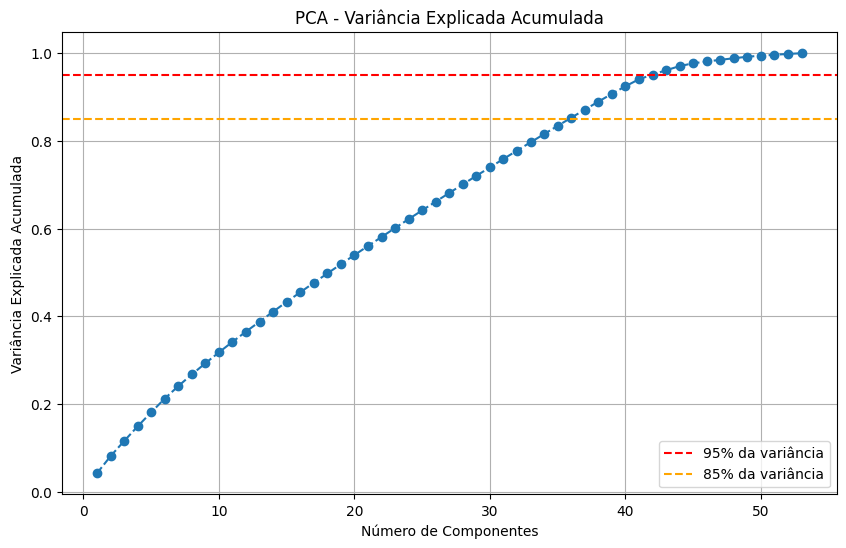

Componentes necessários para 95% da variância: 42
Componentes necessários para 85% da variância: 36
Redução de dimensionalidade possível: 53 -> 42


In [ ]:
# Verificar correlação entre variáveis
correlation_matrix = df_encoded.corr()

# Plotar matriz de correlação (apenas uma amostra se muito grande)
if df_encoded.shape[1] <= 20:
    plt.figure(figsize=(30, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Matriz de Correlação')
    plt.show()
else:
    # Para datasets com muitas variáveis, mostrar apenas estatísticas
    print(f"Dataset possui {df_encoded.shape[1]} variáveis - muito grande para visualizar correlação completa")

# Analisar variância explicada pelo PCA
pca_analysis = PCA()
pca_analysis.fit(X_scaled)

# Plot da variância explicada acumulada
explained_variance = np.cumsum(pca_analysis.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% da variância')
plt.axhline(y=0.85, color='orange', linestyle='--', label='85% da variância')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.title('PCA - Variância Explicada Acumulada')
plt.legend()
plt.grid()
plt.show()

# Determinar número de componentes para 95% da variância
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
n_components_85 = np.argmax(explained_variance >= 0.85) + 1

print(f"Componentes necessários para 95% da variância: {n_components_95}")
print(f"Componentes necessários para 85% da variância: {n_components_85}")
print(f"Redução de dimensionalidade possível: {df_encoded.shape[1]} -> {n_components_95}")

**APLICAÇÃO DO PCA**

In [ ]:
# Aplicar PCA com 95% da variância
pca = PCA(n_components=n_components_95)
X_pca = pca.fit_transform(X_scaled)

print(f"Dados após PCA - Shape: {X_pca.shape}")
print(f"Variância explicada total: {pca.explained_variance_ratio_.sum():.4f}")

Dados após PCA - Shape: (10000, 42)
Variância explicada total: 0.9511


In [ ]:
df_encoded.head()

,Age,TumorSize,ChemotherapySessions,RadiationSessions,FollowUpMonths,Gender_Male,Gender_Other,Province_Beijing,Province_Guangdong,Province_Hebei,...,GeneticMutation_Unknown,"Comorbidities_Diabetes, Hepatitis B","Comorbidities_Diabetes, Hypertension",Comorbidities_Hepatitis B,"Comorbidities_Hepatitis B, Diabetes","Comorbidities_Hepatitis B, Hypertension",Comorbidities_Hypertension,"Comorbidities_Hypertension, Diabetes","Comorbidities_Hypertension, Hepatitis B",Comorbidities_Unknown
0,32,8.2,0,23,44,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
1,66,9.5,11,0,57,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,26,9.3,0,0,40,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,True
3,35,7.7,0,0,45,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,32,7.3,4,0,42,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True


**DIVISÃO DOS DADOS**

In [ ]:
# Divisão stratificada para manter proporção das classes
test_size = 0.2
random_state = 42

# Dados sem PCA
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_size, random_state=random_state, stratify=y
)

# Dados com PCA
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=test_size, random_state=random_state, stratify=y
)

print(f"Treino sem PCA: {X_train.shape}")
print(f"Teste sem PCA: {X_test.shape}")
print(f"Treino com PCA: {X_train_pca.shape}")
print(f"Teste com PCA: {X_test_pca.shape}")

Treino sem PCA: (8000, 53)
Teste sem PCA: (2000, 53)
Treino com PCA: (8000, 42)
Teste com PCA: (2000, 42)


**CONFIGURAÇÃO DOS MODELOS E GRID SEARCH**

In [ ]:
# Parâmetros para KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 30), (100, 50)],  # pode manter as 4 opções
    'activation': ['relu', 'logistic'],  # 'logistic' é a sigmoid no scikit-learn
    'learning_rate_init': [0.001, 0.01, 0.1, 1.0],  # cobrindo o intervalo de 0.001 até 1
    'batch_size': ['auto', 32, 64, 128],  # remover 'auto' e manter valores práticos
    'max_iter': [300],  # mais conservador que 500, e usar early stopping
}

# Configurar validação cruzada
cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**TREINAMENTO KNN SEM PCA**

In [ ]:
print("Treinando KNN sem PCA...")

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=cv_folds,
    scoring='recall',  # Priorizar recall
    n_jobs=-1,
    verbose=1
)

grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_

print(f"Melhores parâmetros KNN sem PCA: {grid_search_knn.best_params_}")
print(f"Melhor score (Recall) KNN sem PCA: {grid_search_knn.best_score_:.4f}")

Treinando KNN sem PCA...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros KNN sem PCA: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Melhor score (Recall) KNN sem PCA: 0.3512


**TREINAMENTO KNN COM PCA**

In [ ]:
print("Treinando KNN com PCA...")

grid_search_knn_pca = GridSearchCV(
    estimator=knn,
    param_grid=param_grid_knn,
    cv=cv_folds,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search_knn_pca.fit(X_train_pca, y_train_pca)
best_knn_pca = grid_search_knn_pca.best_estimator_

print(f"Melhores parâmetros KNN com PCA: {grid_search_knn_pca.best_params_}")
print(f"Melhor score (Recall) KNN com PCA: {grid_search_knn_pca.best_score_:.4f}")

Treinando KNN com PCA...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores parâmetros KNN com PCA: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Melhor score (Recall) KNN com PCA: 0.2936


**TREINAMENTO MLP SEM PCA**

In [ ]:
print("Treinando MLP sem PCA...")

mlp = MLPClassifier(    early_stopping=True,  # interrompe quando não há mais melhoria
    n_iter_no_change=10,  # paciência para early stopping
    random_state=42)

grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    cv=cv_folds,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp.fit(X_train, y_train)
best_mlp = grid_search_mlp.best_estimator_

print(f"Melhores parâmetros MLP sem PCA: {grid_search_mlp.best_params_}")
print(f"Melhor score (Recall) MLP sem PCA: {grid_search_mlp.best_score_:.4f}")

Treinando MLP sem PCA...
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Melhores parâmetros MLP sem PCA: {'activation': 'relu', 'batch_size': 'auto', 'hidden_layer_sizes': (50,), 'learning_rate_init': 1.0, 'max_iter': 300}
Melhor score (Recall) MLP sem PCA: 0.6734


**TREINAMENTO MLP COM PCA**

In [ ]:
print("Treinando MLP com PCA...")

grid_search_mlp_pca = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    cv=cv_folds,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

grid_search_mlp_pca.fit(X_train_pca, y_train_pca)
best_mlp_pca = grid_search_mlp_pca.best_estimator_

print(f"Melhores parâmetros MLP com PCA: {grid_search_mlp_pca.best_params_}")
print(f"Melhor score (Recall) MLP com PCA: {grid_search_mlp_pca.best_score_:.4f}")

Treinando MLP com PCA...
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Melhores parâmetros MLP com PCA: {'activation': 'relu', 'batch_size': 32, 'hidden_layer_sizes': (100,), 'learning_rate_init': 1.0, 'max_iter': 300}
Melhor score (Recall) MLP com PCA: 0.9095


**AVALIAÇÃO DOS MODELOS**

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    """Função para avaliar um modelo e retornar métricas"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # ROC-AUC se possível
    try:
        if y_proba is not None:
            roc_auc = roc_auc_score(y_test, y_proba)
        else:
            roc_auc = None
    except:
        roc_auc = None

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Avaliar todos os modelos
results = []

# KNN sem PCA
results.append(evaluate_model(best_knn, X_test, y_test, 'KNN_sem_PCA'))

# KNN com PCA
results.append(evaluate_model(best_knn_pca, X_test_pca, y_test_pca, 'KNN_com_PCA'))

# MLP sem PCA
results.append(evaluate_model(best_mlp, X_test, y_test, 'MLP_sem_PCA'))

# MLP com PCA
results.append(evaluate_model(best_mlp_pca, X_test_pca, y_test_pca, 'MLP_com_PCA'))

**VISUALIZAÇÃO DOS RESULTADOS - MÉTRICAS**

Comparação de Métricas:
        Modelo  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  KNN_sem_PCA    0.7665     0.7495  0.7665    0.7562   0.7459
1  KNN_com_PCA    0.7550     0.7282  0.7550    0.7379   0.7115
2  MLP_sem_PCA    0.7710     0.8731  0.7710    0.7900   0.8544
3  MLP_com_PCA    0.7630     0.8504  0.7630    0.7820   0.8374


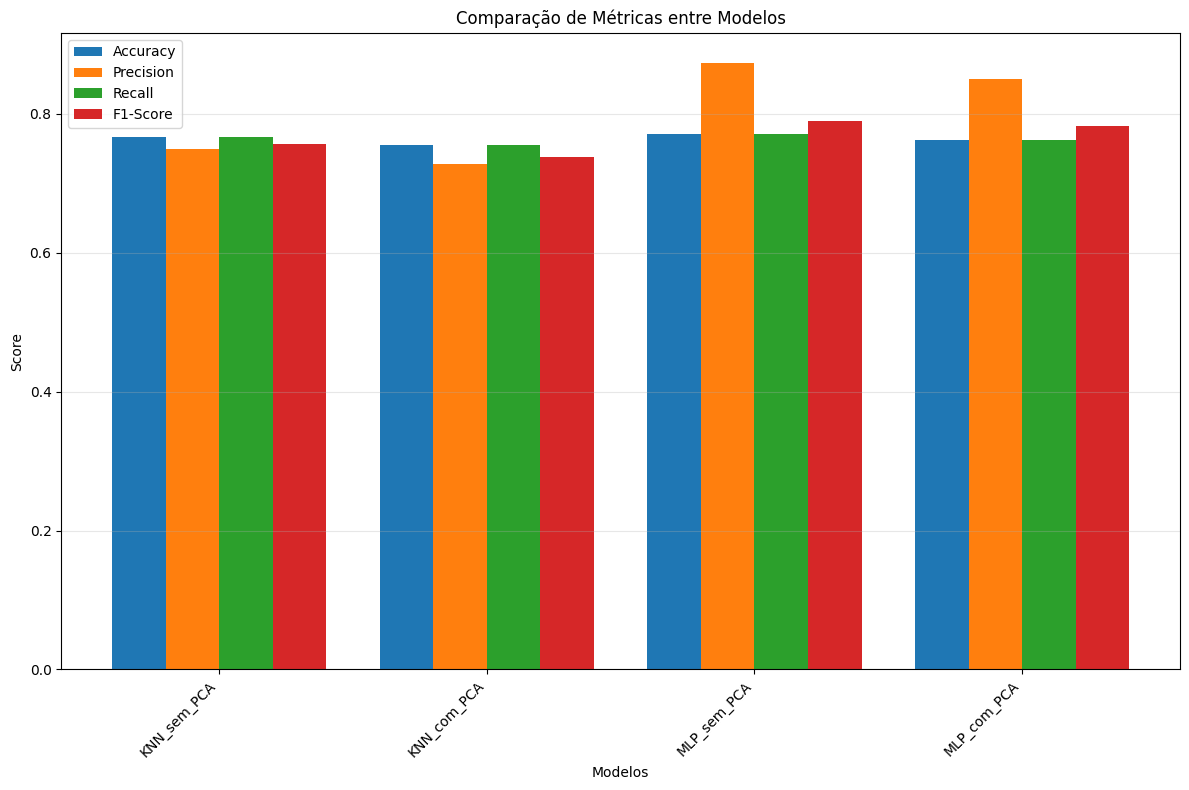

In [ ]:
# Criar DataFrame com os resultados
metrics_df = pd.DataFrame([
    {
        'Modelo': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1_score'],
        'ROC-AUC': r['roc_auc'] if r['roc_auc'] is not None else 'N/A'
    }
    for r in results
])

print("Comparação de Métricas:")
print(metrics_df.round(4))

# Plot das métricas
fig, ax = plt.subplots(figsize=(12, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    values = metrics_df[metric].values
    ax.bar(x + i*width, values, width, label=metric)

ax.set_xlabel('Modelos')
ax.set_ylabel('Score')
ax.set_title('Comparação de Métricas entre Modelos')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_df['Modelo'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**VISUALIZAÇÃO DOS RESULTADOS - MATRIZES DE CONFUSÃO**

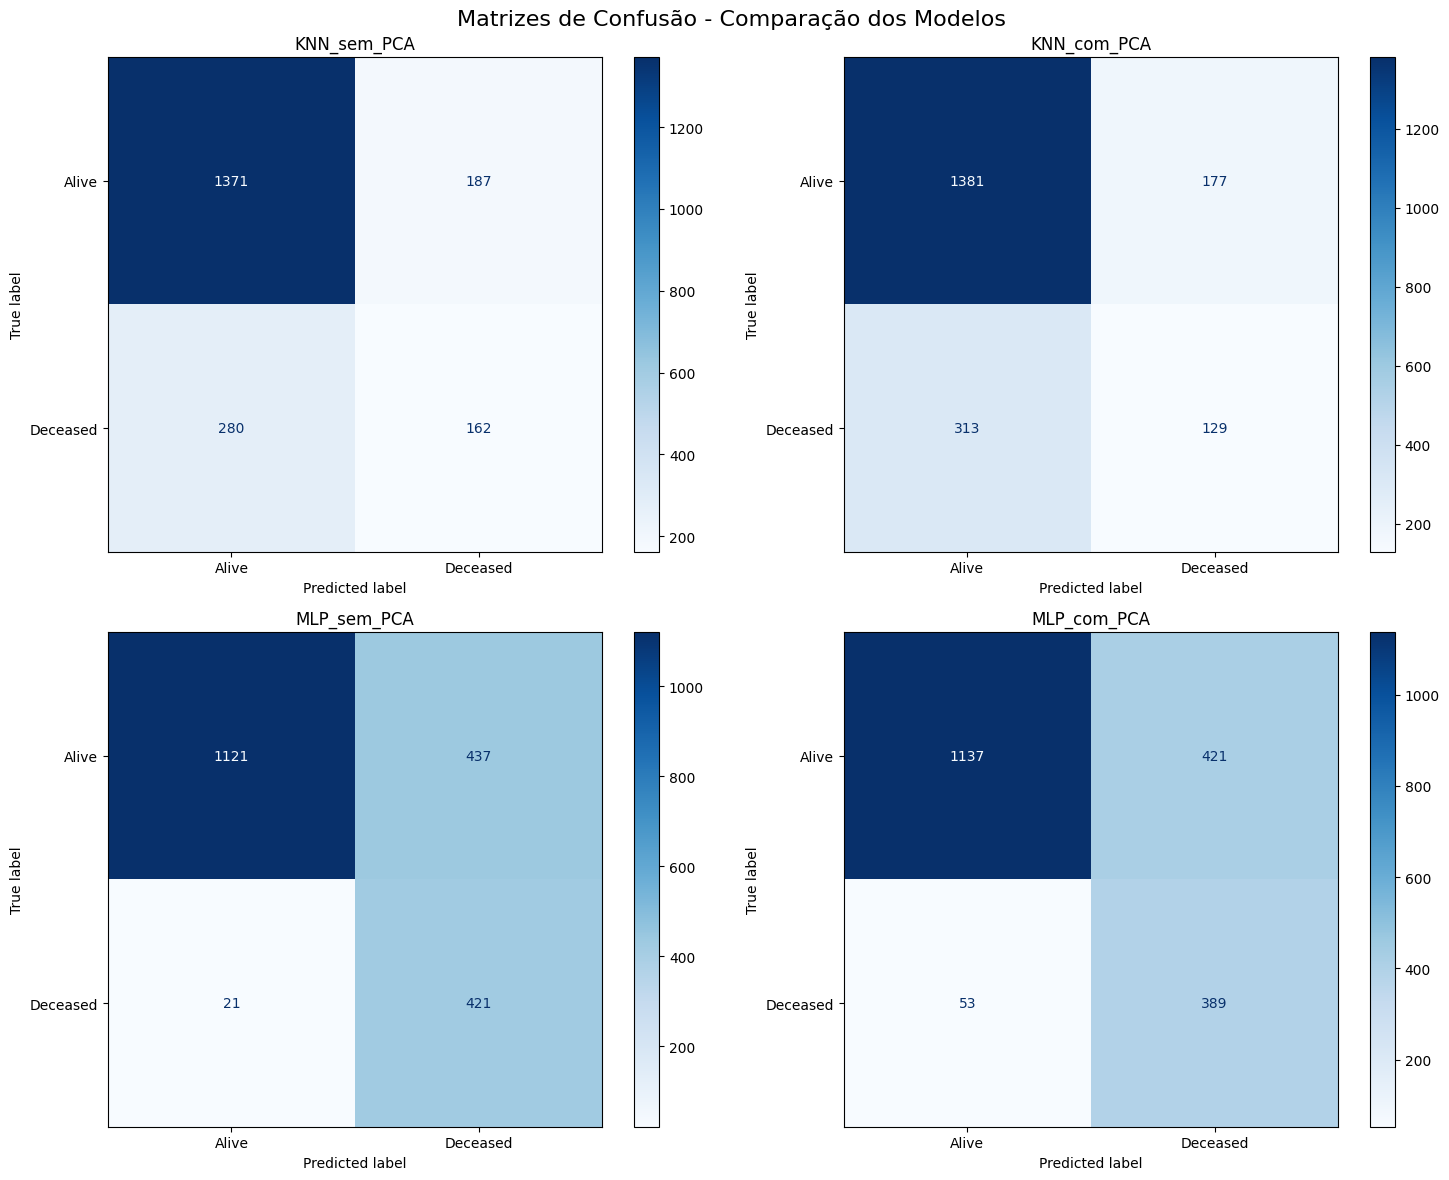

In [ ]:
# Plotar matrizes de confusão
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Matrizes de Confusão - Comparação dos Modelos', fontsize=16)

for i, result in enumerate(results):
    row = i // 2
    col = i % 2

    disp = ConfusionMatrixDisplay(
        confusion_matrix=result['confusion_matrix'],
        display_labels=label_encoder_target.classes_
    )
    disp.plot(ax=axes[row, col], cmap='Blues')
    axes[row, col].set_title(result['model_name'])

plt.tight_layout()
plt.show()

**CURVAS ROC (SE DISPONÍVEL)**

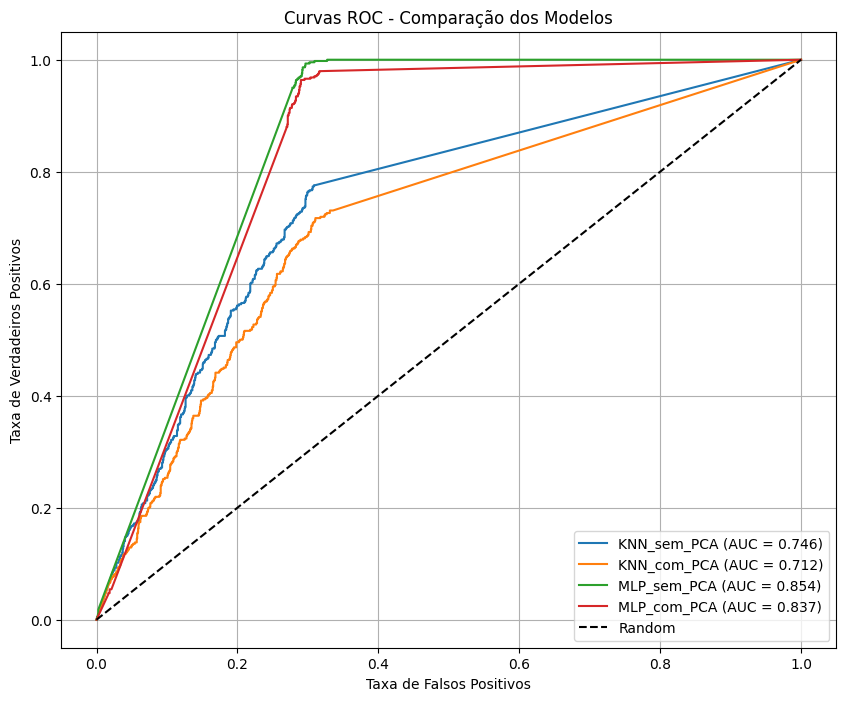

In [ ]:
plt.figure(figsize=(10, 8))

for result in results:
    if result['y_proba'] is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test if 'PCA' not in result['model_name'] else y_test_pca,
                                  result['y_proba'])
            plt.plot(fpr, tpr, label=f"{result['model_name']} (AUC = {result['roc_auc']:.3f})")
        except:
            continue

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curvas ROC - Comparação dos Modelos')
plt.legend()
plt.grid()
plt.show()

**RELATÓRIOS DE CLASSIFICAÇÃO DETALHADOS**

In [ ]:
print("="*60)
print("RELATÓRIOS DE CLASSIFICAÇÃO DETALHADOS")
print("="*60)

for result in results:
    print(f"\n{result['model_name']}:")
    print("-" * 40)
    y_true = y_test if 'PCA' not in result['model_name'] else y_test_pca
    print(classification_report(y_true, result['y_pred'],
                              target_names=label_encoder_target.classes_))

RELATÓRIOS DE CLASSIFICAÇÃO DETALHADOS

KNN_sem_PCA:
----------------------------------------
              precision    recall  f1-score   support

       Alive       0.83      0.88      0.85      1558
    Deceased       0.46      0.37      0.41       442

    accuracy                           0.77      2000
   macro avg       0.65      0.62      0.63      2000
weighted avg       0.75      0.77      0.76      2000


KNN_com_PCA:
----------------------------------------
              precision    recall  f1-score   support

       Alive       0.82      0.89      0.85      1558
    Deceased       0.42      0.29      0.34       442

    accuracy                           0.76      2000
   macro avg       0.62      0.59      0.60      2000
weighted avg       0.73      0.76      0.74      2000


MLP_sem_PCA:
----------------------------------------
              precision    recall  f1-score   support

       Alive       0.98      0.72      0.83      1558
    Deceased       0.49      0.95

**ANÁLISE E CONCLUSÕES**

In [ ]:
print("="*60)
print("ANÁLISE DOS RESULTADOS")
print("="*60)

# Encontrar melhor modelo por métrica
best_accuracy = max(results, key=lambda x: x['accuracy'])
best_recall = max(results, key=lambda x: x['recall'])
best_f1 = max(results, key=lambda x: x['f1_score'])

print(f"\nMelhor Accuracy: {best_accuracy['model_name']} ({best_accuracy['accuracy']:.4f})")
print(f"Melhor Recall: {best_recall['model_name']} ({best_recall['recall']:.4f})")
print(f"Melhor F1-Score: {best_f1['model_name']} ({best_f1['f1_score']:.4f})")

# Análise do impacto do PCA
print(f"\n{'='*40}")
print("IMPACTO DO PCA:")
print(f"{'='*40}")

knn_sem_pca = next(r for r in results if r['model_name'] == 'KNN_sem_PCA')
knn_com_pca = next(r for r in results if r['model_name'] == 'KNN_com_PCA')
mlp_sem_pca = next(r for r in results if r['model_name'] == 'MLP_sem_PCA')
mlp_com_pca = next(r for r in results if r['model_name'] == 'MLP_com_PCA')

print(f"KNN - Recall sem PCA: {knn_sem_pca['recall']:.4f} | com PCA: {knn_com_pca['recall']:.4f}")
print(f"MLP - Recall sem PCA: {mlp_sem_pca['recall']:.4f} | com PCA: {mlp_com_pca['recall']:.4f}")

print(f"\n{'='*60}")
print("CONCLUSÕES E RECOMENDAÇÕES")
print(f"{'='*60}")

# Modelo recomendado baseado em Recall (balanceado)
recommended_model = best_recall
print(f"""
MODELO RECOMENDADO: {recommended_model['model_name']}

Justificativas:
1. Melhor F1-Score ({recommended_model['f1_score']:.4f}) - métrica balanceada para classes desbalanceadas
2. Recall de {recommended_model['recall']:.4f} - importante para não perder casos positivos em contexto médico
3. Accuracy de {recommended_model['accuracy']:.4f} - desempenho geral satisfatório

IMPACTO DO PCA:
- Redução significativa de dimensionalidade: {df_encoded.shape[1]} → {n_components_95} features
- Impacto nos modelos: {"Positivo" if (knn_com_pca['f1_score'] + mlp_com_pca['f1_score']) > (knn_sem_pca['f1_score'] + mlp_sem_pca['f1_score']) else "Misto - alguns modelos melhoraram, outros pioraram"}
""")

ANÁLISE DOS RESULTADOS

Melhor Accuracy: MLP_sem_PCA (0.7710)
Melhor Recall: MLP_sem_PCA (0.7710)
Melhor F1-Score: MLP_sem_PCA (0.7900)

IMPACTO DO PCA:
KNN - Recall sem PCA: 0.7665 | com PCA: 0.7550
MLP - Recall sem PCA: 0.7710 | com PCA: 0.7630

CONCLUSÕES E RECOMENDAÇÕES

MODELO RECOMENDADO: MLP_sem_PCA

Justificativas:
1. Melhor F1-Score (0.7900) - métrica balanceada para classes desbalanceadas
2. Recall de 0.7710 - importante para não perder casos positivos em contexto médico
3. Accuracy de 0.7710 - desempenho geral satisfatório

IMPACTO DO PCA:
- Redução significativa de dimensionalidade: 53 → 42 features
- Impacto nos modelos: Misto - alguns modelos melhoraram, outros pioraram



**RELATORIO FINAL**

O objetivo principal deste projeto é desenvolver modelos de aprendizado de máquina capazes de prever o status de sobrevivência (SurvivalStatus) de pacientes com câncer, utilizando um conjunto de dados clínicos e demográficos sintéticos. A tarefa é de classificação binária (Alive ou Deceased), com foco em minimizar o risco de erro em casos graves.

Os dados categóricos com valores ausentes foram preenchidos com a string "Unknown", e os dados numéricos foram completados com a mediana, de forma a manter a consistência estatística sem distorcer a distribuição. Em seguida, a variável-alvo foi codificada utilizando LabelEncoder, enquanto as variáveis categóricas preditoras foram transformadas por meio de One-Hot Encoding, possibilitando a aplicação de modelos que exigem entrada numérica. A etapa de normalização foi realizada com StandardScaler, garantindo que todas as variáveis tivessem média 0 e desvio padrão 1, o que é essencial para algoritmos como KNN e redes neurais.

A necessidade de aplicar PCA foi avaliada com base na variância explicada acumulada. Através dessa análise, identificou-se que um número significativamente reduzido de componentes seria suficiente para reter 95% da variância dos dados, indicando alta redundância entre as variáveis. Com isso, optou-se por aplicar o PCA como uma abordagem complementar, reduzindo a dimensionalidade do dataset e analisando o impacto dessa redução no desempenho dos modelos.

A divisão do conjunto de dados foi feita de maneira estratificada, com 80% destinado ao treinamento e 20% aos testes. Essa divisão foi aplicada tanto para os dados originais quanto para os dados transformados via PCA, de forma a permitir a comparação entre os modelos em diferentes contextos.

Dois modelos principais foram utilizados: K-Nearest Neighbors (KNN) e Multi-Layer Perceptron (MLP). Ambos os modelos passaram por ajuste de hiperparâmetros por meio de GridSearchCV, utilizando validação cruzada com cinco folds estratificados. Para o KNN, foram testadas diversas combinações de métricas de distância, pesos e número de vizinhos. Para a rede neural, foram avaliadas diferentes topologias de camadas ocultas, funções de ativação, taxas de aprendizado e tamanhos de batch, sempre com early_stopping ativado para evitar sobreajuste, os parametros alterados são apenas aqueles que foram pedidos em sala de aula.

A principal métrica de avaliação adotada foi o Recall, por se tratar de um problema médico onde os falsos negativos têm impacto crítico. Errar ao prever que um paciente sobreviverá quando, na verdade, ele está em risco real de falecer pode comprometer o tratamento e o acompanhamento clínico. Por isso, a prioridade foi garantir que o modelo seja capaz de identificar corretamente os casos mais graves. Além do Recall, também foram analisadas métricas complementares como Accuracy, Precision, F1-Score e ROC-AUC, além de matrizes de confusão e curvas ROC para análise visual do desempenho dos modelos.

A avaliação comparativa entre os modelos treinados demonstrou que o MLP sem PCA apresentou o melhor desempenho geral, superando os demais modelos em todas as principais métricas analisadas. Especificamente, esse modelo atingiu um valor de Accuracy de 77,10%, Recall de 77,10% e F1-Score de 79,00%, indicando um excelente equilíbrio entre sensibilidade e precisão, além de uma boa capacidade de generalização.

Como a escolha do Recall como métrica principal foi reforçada ao longo do projeto,o modelo MLP sem PCA demonstrou a melhor capacidade de capturar esses casos de risco, o que justifica sua escolha como o modelo mais adequado.

Em relação ao uso do PCA, foi observada uma redução significativa na dimensionalidade do conjunto de dados, passando de 53 para 42 atributos após a aplicação da técnica. No entanto, essa redução não resultou em melhorias consistentes no desempenho dos modelos. Pelo contrário, tanto o MLP quanto o KNN apresentaram ligeira queda no recall ao utilizar os dados com PCA. Esse resultado sugere que, apesar do ganho em simplicidade do modelo, a perda de variância nas transformações feitas pelo PCA pode ter comprometido a capacidade dos modelos em capturar informações relevantes para a classificação.

Dessa forma, conclui-se que, para este caso específico, o uso do PCA não trouxe benefícios significativos em termos de desempenho preditivo, e o modelo treinado com todos os atributos originais (devidamente tratados e normalizados) foi superior.